In [1]:
!pip install 'tensorflow[and-cuda]==2.9.0' ampligraph==2.0.1
!pip install pipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.3 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for ampligraph==2.0.1 from https://files.pythonhosted.org/packages/72/09/33f410d9ae49eb3b11f347b098833aac6c0224da4a313bf2639947936dc3/ampligraph-2.0.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 90.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 296.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.5/575.5 kB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.3 MB/s eta 0:00:00:00:01
  Obtaining dependency inf

In [4]:
import numpy as np
import pandas as pd
import ampligraph
import tensorflow as tf

tf.test.is_gpu_available()

True

In [5]:
from pipe import select, where

In [7]:
from rdflib import Graph, URIRef
graph = Graph()
graph.parse('/kaggle/input/knowledge-graph-go/res.ttl', format='ttl')

<Graph identifier=N72ca59a9326741278e779c3c20a8528a (<class 'rdflib.graph.Graph'>)>

In [8]:
def is_not_literal(triplet):
    return isinstance(triplet[0], URIRef) and isinstance(triplet[2], URIRef)

def is_not_rdf_ns(triplet, namespaces_to_skip=("http://www.w3.org/",)):
    predicate_uri = str(triplet[1])
    if any(predicate_uri.startswith(namespace) for namespace in namespaces_to_skip):
        return False
    return True

def normalize(triplet):
    sub, pre, obj = triplet
    
    subject_fragment = sub.split("/")[-1]
    object_fragment = obj.split("/")[-1]
    predicate_fragment = pre.split("#")[-1] if "#" in str(pre) else pre.split("/")[-1]

    return subject_fragment, predicate_fragment, object_fragment

In [9]:
triplets = list(graph.triples((None, None, None)) 
               | where(is_not_literal)
               | where(is_not_rdf_ns)
               | select(normalize))

In [10]:
triplets[1]

('45086', 'isWinner', 'Rin_Kaiho')

In [11]:
df = pd.DataFrame(triplets, columns=['subject', 'predicate', 'object'])

In [12]:
df.predicate.unique()

array(['isLoser', 'isWinner', 'isChampion', 'playedInTournament',
       'inTheCountry', 'isRunnerup', 'representsTheCountry'], dtype=object)

In [13]:
df[(df.subject=="88506") | (df.object=="88506")]

,subject,predicate,object
21846,88506,isLoser,Yun_Junsang
129234,88506,isWinner,Lee_Jihyun_(m)


In [14]:
from ampligraph.evaluation import train_test_split_no_unseen

In [15]:
X_train, X_valid = train_test_split_no_unseen(np.array(triplets), test_size=10000)

In [16]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (223386, 3)
Test set size:  (10000, 3)


In [17]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer

# Initialize a ComplEx neural embedding model
model = ScoringBasedEmbeddingModel(k=128,
                                   eta=30,
                                   scoring_type='ComplEx')


# Optimizer, loss and regularizer definition
optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Compilation of the model
model.compile(optimizer=optim,
              loss=loss,
              entity_relation_regularizer=regularizer)

In [18]:
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)


# Fit the model
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=100,  # Number of training epochs
          verbose=True  # Enable stdout messages
          )

Epoch 1/100
52/52 [==============================] - 6s 107ms/step - loss: 15041.2705
Epoch 2/100
52/52 [==============================] - 3s 62ms/step - loss: 15041.1211
Epoch 3/100
52/52 [==============================] - 3s 62ms/step - loss: 15040.8613
Epoch 4/100
52/52 [==============================] - 3s 62ms/step - loss: 15040.3516
Epoch 5/100
52/52 [==============================] - 3s 62ms/step - loss: 15039.3994
Epoch 6/100
52/52 [==============================] - 3s 62ms/step - loss: 15037.7930
Epoch 7/100
52/52 [==============================] - 3s 62ms/step - loss: 15035.3135
Epoch 8/100
52/52 [==============================] - 3s 62ms/step - loss: 15031.7578
Epoch 9/100
52/52 [==============================] - 3s 62ms/step - loss: 15026.9453
Epoch 10/100
52/52 [==============================] - 3s 62ms/step - loss: 15020.7100
Epoch 11/100
52/52 [==============================] - 3s 63ms/step - loss: 15012.8916
Epoch 12/100
52/52 [==============================] - 3s 63ms/

In [20]:
list(df.itertuples(index=False, name=None))[0:5]

[('63246', 'isLoser', 'Sakai_Hideyuki'),
 ('45086', 'isWinner', 'Rin_Kaiho'),
 ('98625', 'isLoser', 'Motoki_Katsuya'),
 ('31943', 'isWinner', 'Park_Yeonghun'),
 ('56810', 'isLoser', 'Zhang_Zihan')]

In [21]:
X_train

array([['44211', 'isLoser', 'Matsumoto_Takehisa'],
       ['45535', 'isLoser', 'Yang_Dingxin'],
       ['62741', 'isLoser', 'Yun_Yeongseon'],
       ...,
       ['66511', 'isLoser', 'Gan_Siyang'],
       ['18996', 'isWinner', 'Kobayashi_Satoru'],
       ['61571', 'isLoser', 'He_Yuhan']], dtype='<U49')

In [31]:
model.get_embeddings(['Matsumoto_Takehisa'])

array([[ 0.5130388 ,  0.45801544,  0.50904024,  0.48873952,  0.22546342,
        -0.4758851 , -0.450481  ,  0.18258011, -0.48602158,  0.0616455 ,
        -0.4937733 ,  0.4681406 , -0.19880295, -0.47337425,  0.24457748,
        -0.48638743, -0.4702456 , -0.33030352, -0.4294108 ,  0.4393691 ,
        -0.4777219 , -0.11087579,  0.07263983,  0.4233505 , -0.41490445,
        -0.43935382, -0.5111211 , -0.46799117,  0.10609639, -0.51533026,
        -0.46699816, -0.466123  , -0.49627903, -0.5020677 ,  0.34348208,
         0.02590356,  0.2101781 ,  0.41810596,  0.502526  ,  0.48557803,
        -0.49157843, -0.46857873,  0.48383805,  0.46316534, -0.29084647,
         0.5268268 , -0.4882778 , -0.4507418 , -0.49019927,  0.4224121 ,
         0.46621263,  0.26482522,  0.10272376,  0.29973873, -0.5220958 ,
         0.48445427, -0.5179683 ,  0.25385848, -0.5010662 , -0.17283593,
         0.54097825, -0.39354518,  0.4564007 ,  0.47632217, -0.49420503,
        -0.20099337,  0.12867002,  0.49442035,  0.4

In [32]:
df_players = pd.read_csv('/kaggle/input/knowledge-graph-go/df_players.csv')

In [33]:
df_players

,Name,Rating,Sex,Flag,Wins,Losses,Total,Date of Birth
0,Shin Jinseo,3866,man,kr,657,190,847,2000-03-17
1,Park Junghwan,3691,man,kr,893,365,1258,1993-01-11
2,Wang Xinghao,3678,man,cn,156,69,225,2004-02-02
3,Gu Zihao,3678,man,cn,314,192,506,1998-03-13
4,Ke Jie,3666,man,cn,575,247,822,1997-08-02
...,...,...,...,...,...,...,...,...
2266,Tanimiya Ayako,2371,woman,jp,0,15,15,1946-02-02
2267,Tafu Kae,2367,woman,jp,1,13,14,1971-03-13
2268,Han Cheolkyun,2358,man,kr,1,31,32,1955-01-04
2269,Hashiguchi Mika,2290,woman,jp,0,10,10,1963-09-19


In [36]:
df_players['Name'] = df_players['Name'].apply(lambda x: x.replace(' ', '_'))

In [37]:
players_names = df_players['Name'].unique()

In [38]:
players_embeddings = dict(zip(players_names, model.get_embeddings(players_names)))

In [44]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 132 (delta 20), reused 39 (delta 16), pack-reused 87
Receiving objects: 100% (132/132), 66.24 KiB | 2.55 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Processing /kaggle/working/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=25731 sha256=7a4811f9e51a31a0b32373e618ae1e89adbbdb676f2ce468dfc08990ef7e0bf4
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vidh4b9/wheels/85/d8/f8/1c1edf5312ef76d4a9163230beb3fbcde6825c623243fa4087
Successfully built incf.countryutils


In [42]:
!pip install adjustText==0.8

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [46]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in players_embeddings.values()]))

In [103]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players_names, model, clustering_algorithm, mode='e')

In [104]:
plot_df = pd.DataFrame({"teams": players_names,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "flag": df_players['Flag'],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [110]:
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(11, 11))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)
    #texts = []
    #adjust_text(texts)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

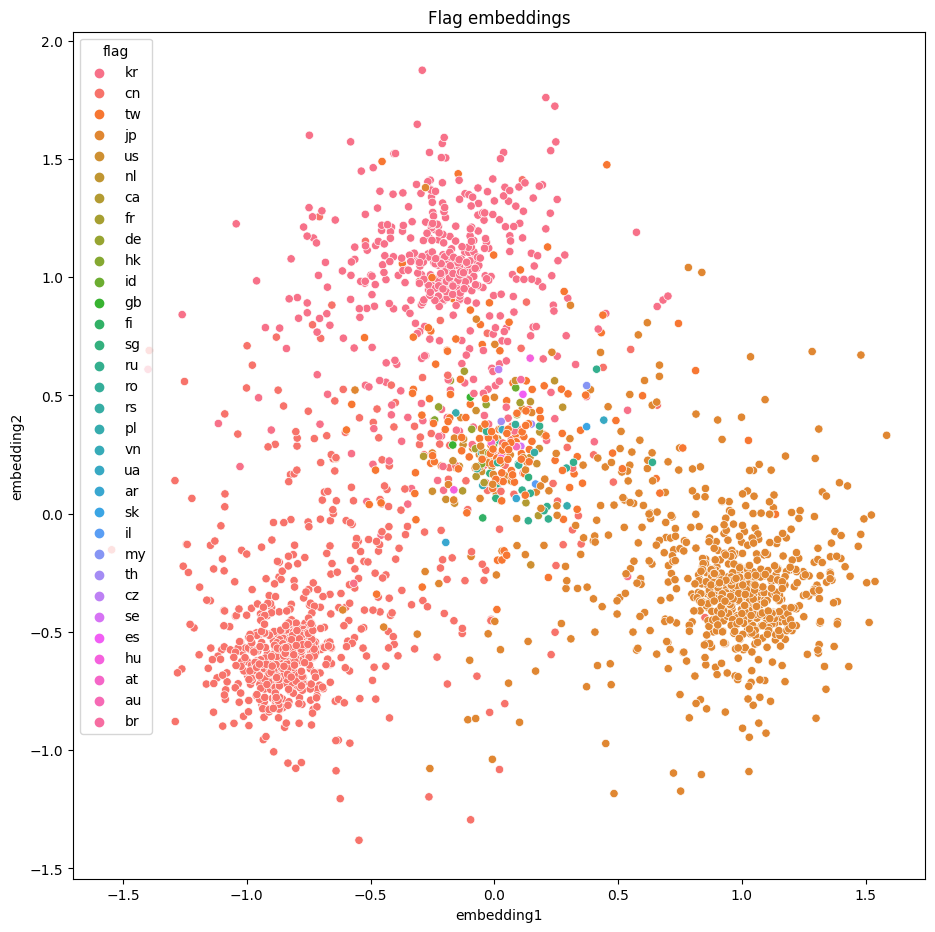

In [111]:
plot_clusters("flag");

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

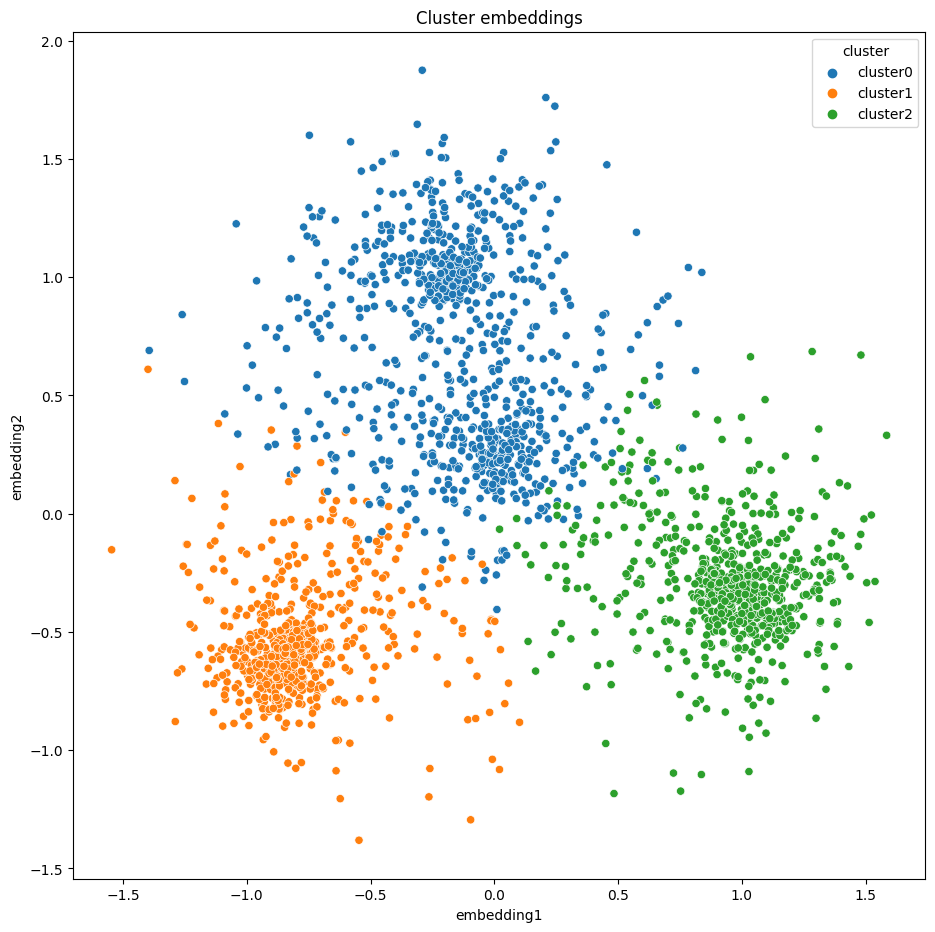

In [112]:
plot_clusters("cluster")

In [113]:
plot_df_1 = plot_df.dropna()

In [114]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df_1.flag, plot_df_1.cluster)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

0.6361125789348189

In [126]:
clustering_algorithm = KMeans(n_clusters=5, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players_names, model, clustering_algorithm, mode='e')

In [127]:
plot_df = pd.DataFrame({"teams": players_names,
                        "embedding1": embeddings_2d[:, 0],
                        "embedding2": embeddings_2d[:, 1],
                        "flag": df_players['Flag'],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

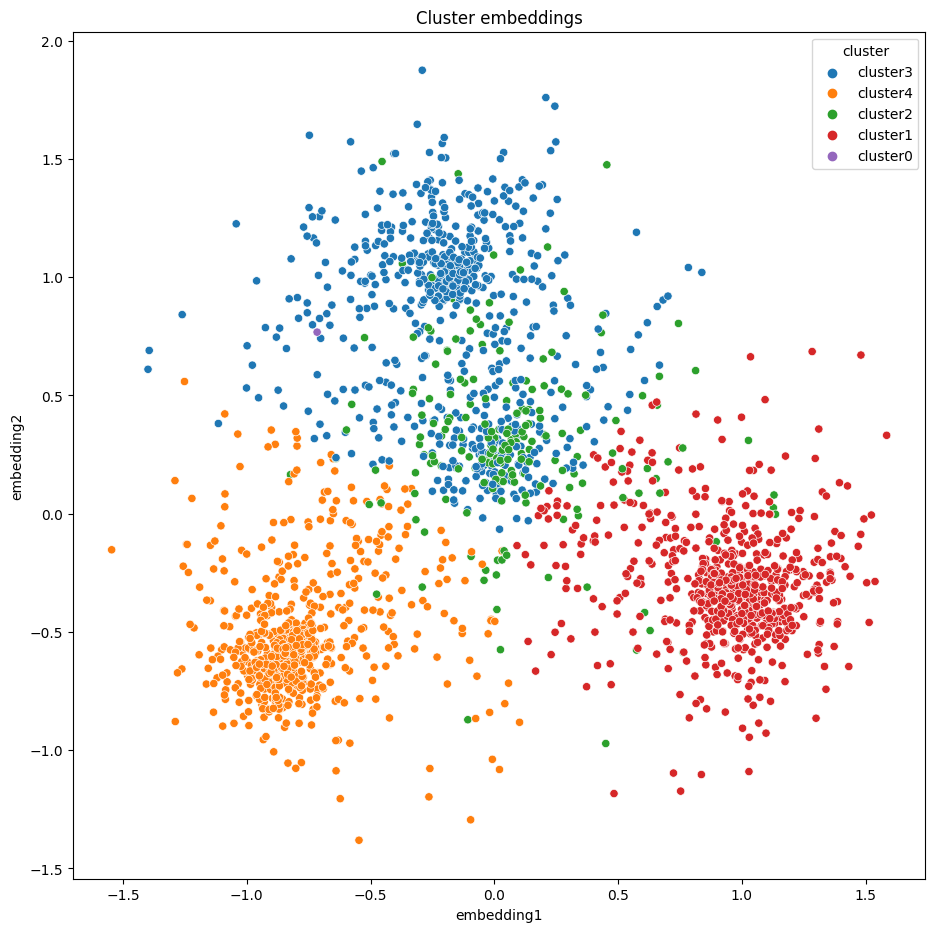

In [129]:
plot_clusters("cluster")

In [131]:
plot_df_1 = plot_df.dropna()

In [132]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df_1.flag, plot_df_1.cluster)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

0.7426161617691514